# 目的
あるクラウドファンディングが成功するか(state)を事前に予測するモデルを構築する。

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler # 標準化
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV # 特徴抽出にLASSOを使う
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト(分類)
from sklearn.model_selection import GridSearchCV #グリッドサーチ
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

# データの読み込み

## データの扱いについて
| Variables | 変数 | 使う? | 変数の扱い |
| ---- | ---- | ---- |  ---- |
| ID | internal kickstarter id | - | - |
| name | プロジェクト名 | - | - |
| category | カテゴリー | ○ | ダミー変数 |
| main_category | category of campaign | ○ | ダミー変数 |
| currency | 通貨 | ○ | ダミー変数 |
| deadline | 期限 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| goal | 目標金額 | ○ | 数値(金額) |
| launched | 開始日 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| pledged | 集まった金額 | - (開始時にはわからないので使わない) | - |
| state | 成否 | ※目的変数 | fiailled: 0, successful: 1, Other: 捨てる(Pandasで) |

↓CSVデータを読み込み、データの整形を行う。

In [20]:
#ks_projects_data = pd.read_csv("ks-projects-201801.csv")[['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'state']]

# 全データを読み込む
ks_projects_data = pd.read_csv("ks-projects-201801.csv")
display(ks_projects_data.head())
ks_projects_data.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [21]:
#欠損値確認
#ks_projects_data.info()
#ks_projects_data.isnull().sum()

# currency と country の対応を確認
#print(ks_projects_data['currency'].value_counts())
#print(ks_projects_data['country'].value_counts())
# ほぼ同じ情報を持っているので、使うのは currency だけにする。

In [22]:
# state が failed と successful 以外の行を削除 
# indexが連番じゃなくなるので reset_index() で連番に直す
ks_projects_data2 = ks_projects_data[ks_projects_data['state'].isin(['failed','successful'])].reset_index(drop=True)

# 欠損値の確認
ks_projects_data2.isnull().sum()

# name と usd_pledged に欠損値があるが、usd_pledged は今回使わないので補完は行わない。
# name は今のところ使わない予定だが、使う場合はそのタイミングで補完を行う。

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

In [23]:
# deadline - launched で募集期間を算出する
# pd.to_datetime() を使って、str を datetime64型に変換
# 日数(int)で出したいので、Series.dt() を使って変換
ks_projects_data2['launched'] = pd.to_datetime(ks_projects_data2['launched'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['deadline'] = pd.to_datetime(ks_projects_data2['deadline'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['duration'] = (ks_projects_data2['deadline'] - ks_projects_data2['launched']).dt.days
display(ks_projects_data2.head())
#print(type(ks_projects_data2.loc[0,'state']))
#display(ks_projects_data2['state'].value_counts())
#display(ks_projects_data2['currency'].value_counts())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00,34


In [ ]:
#print(ks_projects_data2["state"])
#print(ks_projects_data2["state"]=="successful")
#print((ks_projects_data2["state"]=="successful").values)
# bool型のTrueとFalseはint型の1,0と等価


In [24]:
# state を succesful = True, failed = False に置換する
#ks_projects_data2 = ks_projects_data2.replace({'state': {'failed': 0, 'successful': 1}})
#display(ks_projects_data2.head())
ks_projects_data2["state"] = ks_projects_data2["state"]=="successful"
display(ks_projects_data2.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,1,US,1.0,1.0,5000.00,29
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,True,224,US,52375.0,52375.0,50000.00,34


In [ ]:
# グラフを書いてデータを確認する。
fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.boxplot("state", "duration", data=ks_projects_data2, ax=ax[0])
sns.boxplot("state","usd_goal_real", data=ks_projects_data2, ax=ax[1]) 

# 募集期間は外れ値が多いが、成功は20~40ぐらいに分布しており、失敗は15~55ぐらいに分布している。
# 分布の幅が異なるので説明変数として使えそう。

# 目標金額が大きいものは失敗が多い。
# 目標金額が小さくても失敗しているものはあるので、目標金額だけで分類はできない。
# 目標金額が大きくなると失敗する傾向があるので、説明変数として使えそう。



In [ ]:
# 成功と失敗で DataFrameを分ける
ks_projects_data_successful = ks_projects_data2[(ks_projects_data2['state'] == True)].copy().reset_index(drop=True)
ks_projects_data_failed = ks_projects_data2[(ks_projects_data2['state'] == False)].copy().reset_index(drop=True)

# durationとusd_goal_readlの
fig2,ax2 = plt.subplots(1,2, figsize=(10,5))
sns.regplot('duration', 'usd_goal_real', data=ks_projects_data_successful, marker='.', color='red', ax=ax2[0])
sns.regplot('duration', 'usd_goal_real', data=ks_projects_data_failed, marker='x', color='blue', ax=ax2[1])



In [25]:
# durationとusd_goal_realの相関係数を計算
correlation = ks_projects_data2['duration'].corr(ks_projects_data2['usd_goal_real'])
print(correlation)

# durationとusd_goal_realは相関が無い

0.021606743271616113


## 学習に使うデータを準備

In [26]:
# 説明変数として使用する列だけ抽出
ks_projects_data3 = ks_projects_data2[['state', 'main_category', 'category', 'currency', 'usd_goal_real', 'duration']]

# main_category と currency をダミー変数にする
ks_projects_data3 = pd.get_dummies(ks_projects_data3, columns=['main_category', 'category', 'currency'])
display(ks_projects_data3.head())

# 学習用データとテストデータに分ける
# ホールドアウト法を使う
X_n = ks_projects_data3.drop('state', axis=1)
y_n = ks_projects_data3['state']

X = X_n.values
y = y_n.values

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# usd_goal_real と duration を標準化する
stdsc = StandardScaler()
X_train_stand[:,0] = stdsc.fit_transform(X_train[:,0].reshape(-1,1)).reshape(1,-1)
X_test_stand[:,0] = stdsc.transform(X_test[:,0].reshape(-1,1)).reshape(1,-1)

X_train_stand[:,1] = stdsc.fit_transform(X_train[:,1].reshape(-1,1)).reshape(1,-1)
X_test_stand[:,1] = stdsc.transform(X_test[:,1].reshape(-1,1)).reshape(1,-1)
display(ks_projects_data3.head())


,state,usd_goal_real,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,False,1533.95,58,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,30000.00,59,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,False,45000.00,44,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,False,5000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,True,50000.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,state,usd_goal_real,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,False,1533.95,58,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,30000.00,59,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,False,45000.00,44,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,False,5000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,True,50000.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## LASSOによる特徴選択

In [27]:
# LASSO(L1正則化)を使って特徴選択を行う。
estimator = LassoCV(normalize=True, cv=10)

# 閾値は1e-5以下とする。
sfm = SelectFromModel(estimator, threshold=1e-5)

In [28]:
# fitで特徴選択を実行
sfm.fit(X_train_stand, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [29]:
# get_support関数で使用する特徴のインデックスを確認
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,

In [30]:
# 削除すべき特徴の名前を取得
removed_idx = ~sfm.get_support()
remove_feature = X_n.columns[removed_idx]

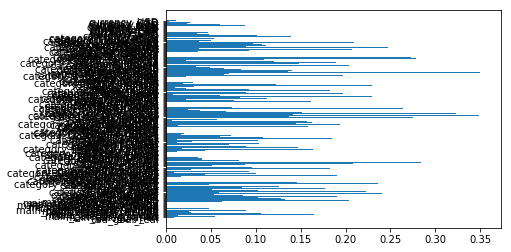

In [31]:
# LASSOで得た各特徴の係数を確認
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

# 係数をグラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=X_n.columns.values)
plt.show()

In [32]:
# drop関数で特徴を削除
X_n2 = X_n.drop(remove_feature, axis=1)

In [33]:
# 特徴削除後のデータで学習データテストデータを作成する。
X = X_n2.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# usd_goal_real と duration を標準化する
stdsc = StandardScaler()
X_train_stand[:,0] = stdsc.fit_transform(X_train[:,0].reshape(-1,1)).reshape(1,-1)
X_test_stand[:,0] = stdsc.transform(X_test[:,0].reshape(-1,1)).reshape(1,-1)

X_train_stand[:,1] = stdsc.fit_transform(X_train[:,1].reshape(-1,1)).reshape(1,-1)
X_test_stand[:,1] = stdsc.transform(X_test[:,1].reshape(-1,1)).reshape(1,-1)




In [34]:
# 学習用データを使ってロジスティック回帰モデルで学習する
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train_stand, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
print("w0 = {:.3f}".format(w0))

wn = []
for i in range(len(clf.coef_[0])):
    wn.append(clf.coef_[0,i])
    print("w{} = {:.3f}".format(i+1, wn[i]))



w0 = -0.931
w1 = -15.024
w2 = -0.174
w3 = -0.087
w4 = 0.769
w5 = -0.541
w6 = 0.187
w7 = 0.134
w8 = -0.394
w9 = -0.169
w10 = 0.487
w11 = -0.062
w12 = -0.319
w13 = 0.904
w14 = 1.003
w15 = -0.592
w16 = 0.449
w17 = -0.793
w18 = -0.408
w19 = -0.067
w20 = 0.994
w21 = -0.282
w22 = -1.438
w23 = -0.216
w24 = 0.317
w25 = 0.785
w26 = -0.406
w27 = -0.733
w28 = 0.147
w29 = 1.462
w30 = -0.984
w31 = 0.512
w32 = -0.229
w33 = 2.489
w34 = 0.127
w35 = 0.760
w36 = 0.225
w37 = 0.233
w38 = -0.109
w39 = -0.552
w40 = -0.192
w41 = 0.666
w42 = -0.516
w43 = -0.375
w44 = -0.506
w45 = 1.050
w46 = 1.062
w47 = -0.308
w48 = 0.360
w49 = 0.312
w50 = -0.068
w51 = -0.496
w52 = -0.421
w53 = -0.826
w54 = -0.239
w55 = 0.574
w56 = -0.177
w57 = -0.637
w58 = 0.283
w59 = -0.816
w60 = -0.304
w61 = 0.278
w62 = -0.443
w63 = 0.038
w64 = 0.168
w65 = -2.646
w66 = -0.051
w67 = -1.003
w68 = 0.645
w69 = 0.675
w70 = -0.195
w71 = 0.126
w72 = 0.168
w73 = 0.089
w74 = 0.989
w75 = -1.537
w76 = -0.032
w77 = 0.675
w78 = -0.079
w79 = 0.784
w80 =

In [35]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_train, y_pred_train)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_pred_train),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)


対数尤度 = -11.536
正答率(Accuracy) = 66.600%
適合率(Precision) = 60.239%
再現率(Recall) = 51.313%
F1値(F1-score) = 55.419%


,予測 = 失敗,予測 = 成功
正解 = 失敗,121632,36359
正解 = 成功,52265,55084


## Day1との比較
| - | Day1 | Day2 |
| --- | --- | --- |
| 対数尤度 | -13.885 | -12.240 | 
| 正答(Accuracy) | 59.799% | 64.562% |
| 適合率(Precision) | 56.161% | 59.970% |
| 再現率(Recall) | 2.110% | 37.386% |
| F1値(F1-score) | 4.067% | 46.058% |

説明変数を標準化することでDay1より予測精度が上がっている。

In [37]:
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_test, y_pred_test)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)


対数尤度 = -11.567
正答率(Accuracy) = 66.511%
適合率(Precision) = 59.563%
再現率(Recall) = 51.408%
F1値(F1-score) = 55.185%


,予測 = 失敗,予測 = 成功
正解 = 失敗,30442,9286
正解 = 成功,12929,13678


## 学習データとテストデータの比較
| - | 学習データ | テストデータ |
| --- | --- | --- |
| 対数尤度 | -12.240 | -12.170 | 
| 正答(Accuracy) | 64.562% | 64.766% |
| 適合率(Precision) | 59.970% | 60.003% |
| 再現率(Recall) | 37.386% | 37.054% |
| F1値(F1-score) | 46.058% | 45.815% |

ほとんど同じ値なので、過学習はしていない。
説明変数にCategoryを加えて、LASSOによる特徴量削減を行うことでAccuracyが向上した。
64.562% → 66.511%

## SVM

In [ ]:
#SVMは時間がかかるので、後で学習用データを減らして実行する。
'''
C = 5
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train_stand, y_train)
'''

In [ ]:
'''
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_train, y_pred_train)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_pred_train),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)
'''

## ランダムフォレスト

In [20]:
# グリッドサーチを用いてハイパーパラメータの探索
parameters = {
    'n_estimators':[100,500,1000], 
    'criterion':['gini'], 
    'min_samples_leaf':[2,10,100,500,1000], 
    
    'min_samples_split':[2,10,100,500,1000],
    'random_state':[1234]
}
model = RandomForestClassifier()

clf2 = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
clf2.fit(X_train_stand, y_train)
print(clf2.best_params_, clf2.best_score_)

{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 100, 'random_state': 1234} 0.6830142458732192


In [21]:
# 最適パラメータでモデル作成
#clf2_rf = RandomForestClassifier(n_estimators=500, criterion="gini", min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf2_rf = RandomForestClassifier(**clf2.best_params_)
clf2_rf.fit(X_train_stand, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [22]:
# 学習データに対する予測を実行
y_pred_train = clf2_rf.predict(X_train_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_train, y_pred_train)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_pred_train),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)

対数尤度 = -10.109
正答率(Accuracy) = 70.732%
適合率(Precision) = 67.401%
再現率(Recall) = 53.562%
F1値(F1-score) = 59.690%


,予測 = 失敗,予測 = 成功
正解 = 失敗,130182,27809
正解 = 成功,49851,57498


In [23]:
# テストデータに対する予測を実行
y_pred_test = clf2_rf.predict(X_test_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_test, y_pred_test)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)

# テストデータの予測より正答率が低いので過学習してる？

対数尤度 = -10.986
正答率(Accuracy) = 68.192%
適合率(Precision) = 62.952%
再現率(Recall) = 50.299%
F1値(F1-score) = 55.919%


,予測 = 失敗,予測 = 成功
正解 = 失敗,130182,27809
正解 = 成功,49851,57498


## アダブースト

In [ ]:
# グリッドサーチ

In [ ]:
# グリッドサーチを用いて最適パラメータの探索
parameters = {
    'n_estimators':[100,200,300], 
#    'criterion':['gini'], 
    'base_estimator__min_samples_leaf':[2,10,100], 
    'base_estimator__min_samples_split':[2,10,100],
    'base_estimator__random_state':[1234]
}
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None), random_state=1234)

clf3 = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
clf3.fit(X_train_stand, y_train)
print(clf3.best_params_, clf3.best_score_)

    


In [ ]:
# 最適パラメータでモデル作成
clf3_ad = AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=2,
    min_samples_split=2, 
    random_state=1234,
    criterion="gini"),
    n_estimators=10, random_state=1234
)


## ニューラルネットワーク

In [38]:
# one-hotベクトルに変更
from tensorflow.keras.utils import to_categorical
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)

In [39]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=175))
model.add(Dense(200, activation='relu', input_dim=6))
model.add(Dense(2, activation='sigmoid')) #2値分類なのでsigmoidにした。


sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)


model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 265340 samples, validate on 66335 samples
Epoch 1/50
265340/265340 [==============================] - 16s 62us/sample - loss: 0.6161 - acc: 0.6575 - val_loss: 0.6063 - val_acc: 0.6651
Epoch 2/50
265340/265340 [==============================] - 15s 58us/sample - loss: 0.6061 - acc: 0.6647 - val_loss: 0.6062 - val_acc: 0.6630
Epoch 3/50
265340/265340 [==============================] - 15s 58us/sample - loss: 0.6025 - acc: 0.6674 - val_loss: 0.6036 - val_acc: 0.6664
Epoch 4/50
265340/265340 [==============================] - 15s 58us/sample - loss: 0.6003 - acc: 0.6692 - val_loss: 0.6004 - val_acc: 0.6694
Epoch 5/50
265340/265340 [==============================] - 16s 59us/sample - loss: 0.5987 - acc: 0.6705 - val_loss: 0.6020 - val_acc: 0.6671
Epoch 6/50
265340/265340 [==============================] - 15s 58us/sample - loss: 0.5975 - acc: 0.6715 - val_loss: 0.5992 - val_acc: 0.6705
Epoch 7/50
265340/265340 [==============================] - 16s 59us/sample - loss: 0.5961 - acc:

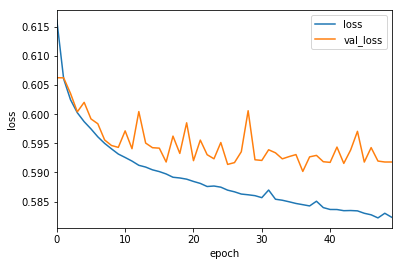

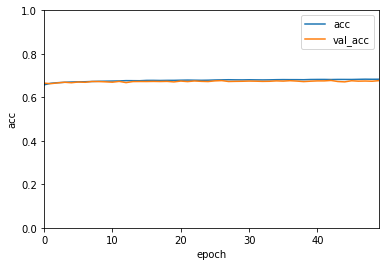

In [40]:
fit = model.fit(X_train_stand, y_train2, 
          epochs=50,
          batch_size=20,validation_data=(X_test_stand, y_test2))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [27]:
from tensorflow.compat.v1.keras.models import load_model

# 保存
model.save('my_model.h5')
del model

# 読み込み
model = load_model('my_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [28]:
y_pred = np.argmax(model.predict(X_test_stand),axis=1)

In [29]:
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [30]:
y_test

array([False,  True, False, ...,  True, False, False])

In [31]:
# テストデータに対する予測を実行
y_pred_test_nn = np.argmax(model.predict(X_test_stand),axis=1)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test_nn)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test_nn)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y_test, y_pred_test_nn)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[1]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[1]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test_nn),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)


対数尤度 = -11.278
正答率(Accuracy) = 67.348%
適合率(Precision) = 60.013%
再現率(Recall) = 55.718%
F1値(F1-score) = 57.786%


,予測 = 失敗,予測 = 成功
正解 = 失敗,29850,9878
正解 = 成功,11782,14825


# 予測結果まとめ

| モデル | ロジスティック回帰 | ランダムフォレスト | ニューラルネットワーク |
| --- | --- | --- | --- |
| 対数尤度 |  -11.567 | -10.986 | -11.278 |
| 正答率(Accuracy) | 66.511% | 68.192% | 67.348% |
| 適合率(Precision) | 59.563% | 62.952% | 60.013% |
| 再現率(Recall) | 51.408% | 50.299% | 55.718% |
| F1値(F1-score) | 55.185 | 55.919% | 57.786% |

ランダムフォレストの正答率68.129%が最高だった。
SVMとアダブーストは計算が終わらず結果が出なかった。
